In [169]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

In [170]:
#read the data
df = pd.read_csv('Insurance Fraud Data.csv')
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


### **Data Understanding**

In this step, I seek to understand the key attributes of the data. This data structure & data types of the columns, number of rows and columns, and a quick view of data inconsistency such as missing values, duplicates, class imbalance. 

This step also involves descriptive statistics and data quality checks.

**Summary statistics**

This step will provide a summary of statistical aspects of numerical columns such as: 
* Total count of entries per column
* Mean
* Std deviation
* Min and Max
* Quartiles

Summary statistics are important because they gives an idea, just by looking, of whether there are any inconsistencies such as outliers(indicated by abnormally large numbers or negative values for attributes that should not be less than 0),zero values where a value should not be zero like age.

In [171]:
#function to perform data understanding
def data_understanding(df):
    #basic info
    print('Basic info')
    df.info()

    #summary statistics
    print(f"Summary statistics:\n{df.describe(include='all')}") 

    #duplicates
    print(f'Duplicated rows: {df.duplicated().sum()}')

    #missing values
    print(f'Missing values: {df.isnull().any().sum()}')

In [172]:
data_understanding(df)

Basic info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          154

### Interpretation of column types

It is evident from the above summary that a good number of columns are categorical. This includes variables that are meant to be numeric, such as VehiclePrice, Days_Polict_Claim and others. This indicates data inconsistency because a closer look at the first few rows shows that these values are indicates as ranges, such as 2 to 4, which is ordinal.They therefore need to be mapped for feature engineering, a step we will perform in data cleaning.

### Outlier detection

In [173]:
def outlier_check_boxplot(df, figsize=(12, 6)):
    df.select_dtypes(include='number').boxplot(figsize=figsize)
    plt.tight_layout()
    plt.show()

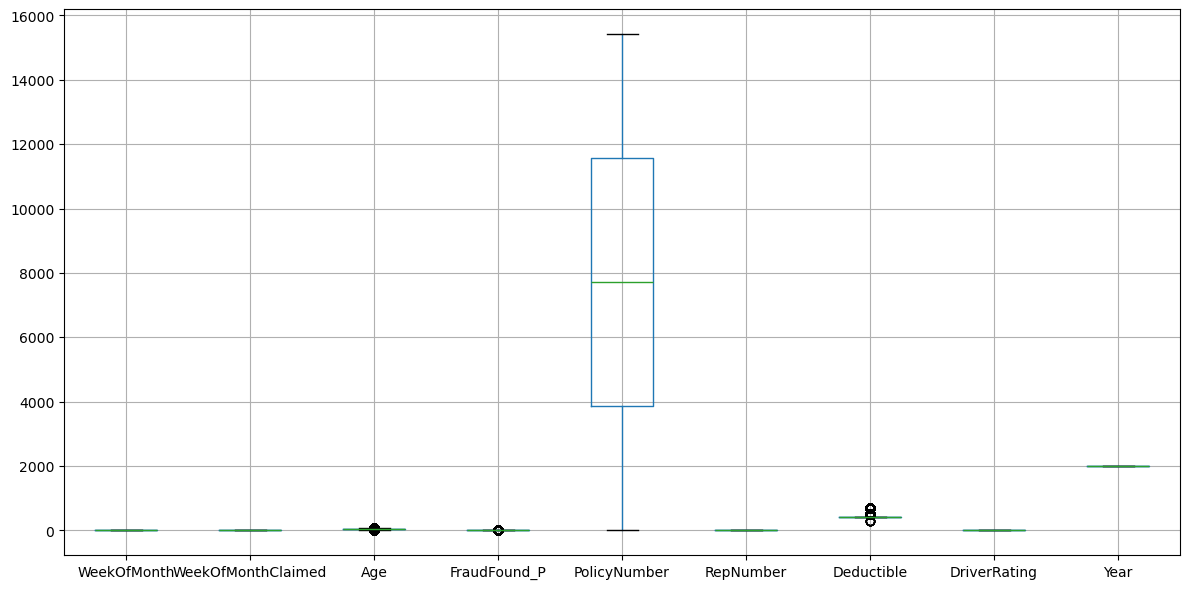

In [174]:
outlier_check_boxplot(df)

From the above, we see there are no duplicated rows, no missing values. These will therefore not be handled in data cleaning.

However, there are outliers in two columns:
* Age
* Deductible

The target column is not counted as having outliers because the less appearing values represent the minority class.

However, most columns are categorical, which means that will be handled in data cleaning. They will be converted to numerical values to enable further computation. 

### Further outlier detection

To clearly understand the outliers in the two numerical columns, we proceed to pick them out from the data, using the IQR.

In [175]:
#defining the IQR function
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

#apply function to Age and Deductible columns
age_outliers = detect_outliers_iqr(df, 'Age')
deductible_outliers = detect_outliers_iqr(df, 'Deductible')

#print outliers
print("Age outliers:\n", age_outliers.value_counts())
print("\nDeductible outliers:\n", deductible_outliers.value_counts())

Age outliers:
 Age
0     320
76     42
74     35
78     35
75     34
80     32
77     29
79     20
Name: count, dtype: int64

Deductible outliers:
 Deductible
700    311
500    263
300      8
Name: count, dtype: int64


### Target variable

FraudFound_P
0    14497
1      923
Name: count, dtype: int64
FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64


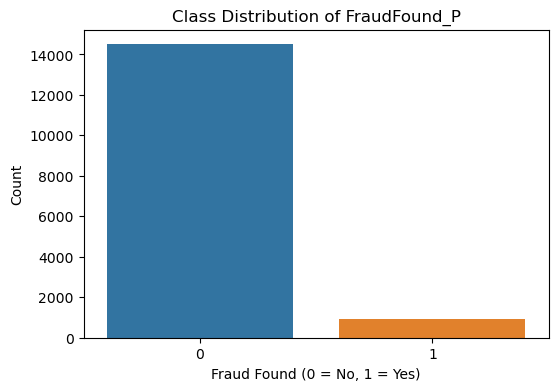

In [176]:
#understanding the target variable
print(df['FraudFound_P'].value_counts())

#percentage of imbalance
print(df['FraudFound_P'].value_counts(normalize=True) * 100)

#plotting the imbalance
plt.figure(figsize=(6,4))
sns.countplot(x='FraudFound_P', data=df)
plt.title('Class Distribution of FraudFound_P')
plt.xlabel('Fraud Found (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

 ## **Data Cleaning**

During data understanding, outliers were identified in the Age column; **320** was detected for ages **0**, which is clearly a data entry error since no person aged zero can own or drive a vehicle. In fact, it is not possile to be aged zero. I wil proceed to remove this outlier from the dataset. 

The remaining outlier ages, **74–80 years** will be retained, as they correspond to realistic policyholder ages despite being less frequent.

In the Deductible column, values of **300**, **500** and **700** were identified as outliers due to their low frequency compared to the dominant deductible of 400. However, they seem to be legitimate and will therefore be retained, as they could provide useful information for predicting fraudulent claims. This will preserve genuine variability thus ensuring model reliability and robust learning. 

### Outlier handling

In [177]:
#remove Age outliers 
df = df[df['Age'] != 0]

In [178]:
#confirming the 320 rows have been removed
df.shape

(15100, 33)

In [179]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


### Mapping textual numeric values to ordinal numeric representations

Seeing that some of the 'object' columns are actually meant to be numeric but stored as strings (e.g more than 69000 for vehicle price, 2 to 4, 'none'), we will clean them into usable numeric values first, so that we can do feature engineering before later performing encoding for categorical variables. 

In [180]:
#list of columns to check
cols_to_check = ['VehiclePrice', 'PastNumberOfClaims', 'Days_Policy_Accident', 'Days_Policy_Claim',
                 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 
                 'AddressChange_Claim', 'NumberOfCars']

#loop through each column and print value counts
for col in cols_to_check:
    print(f"\n Value counts for: {col}")
    print(df[col].value_counts(dropna=False))


 Value counts for: VehiclePrice
VehiclePrice
20000 to 29000     8079
30000 to 39000     3532
more than 69000    1846
less than 20000    1095
40000 to 59000      461
60000 to 69000       87
Name: count, dtype: int64

 Value counts for: PastNumberOfClaims
PastNumberOfClaims
2 to 4         5378
none           4243
1              3509
more than 4    1970
Name: count, dtype: int64

 Value counts for: Days_Policy_Accident
Days_Policy_Accident
more than 30    14927
none               55
8 to 15            55
15 to 30           49
1 to 7             14
Name: count, dtype: int64

 Value counts for: Days_Policy_Claim
Days_Policy_Claim
more than 30    15023
15 to 30           56
8 to 15            21
Name: count, dtype: int64

 Value counts for: AgeOfVehicle
AgeOfVehicle
7 years        5807
more than 7    3980
6 years        3448
5 years        1357
4 years         229
3 years         151
2 years          73
new              55
Name: count, dtype: int64

 Value counts for: AgeOfPolicyHolder
AgeO

### Defining the function to perform the cleaning/mapping

We will use a custom function **text_to_numeric** to convert text-based numeric values into usable numbers. The function 
* replaces ranges such as **20000 to 29000** with their midpoints and
* converts expressions like **less than** or **more than** into reasonable numeric values that maintain the correct order of magnitude.

We will apply this to all object-type variables that actually represent numeric quantities, so that they can be used for feature engineering and modeling without losing their original meaning. 

In [181]:
#function to convert text to numeric
def text_to_numeric(val, column_name=None):
    if pd.isna(val):
        return 0
    val = str(val).strip().lower()
    
    #convert 'none' to 0
    if val == 'none' or val == '0':
        return 0
    #for the AddressChange_Claim case because it has months
    if column_name == 'AddressChange_Claim':
        if 'under' in val and 'month' in val:
            return 0.5
    
    #handle ranges like '2 to 4'
    match_range = re.match(r'(\d+)\s*to\s*(\d+)', val)
    if match_range:
        return (int(match_range.group(1)) + int(match_range.group(2))) / 2
    
    #handle 'more than ..'
    match_more = re.match(r'more than (\d+)', val)
    if match_more:
        return int(match_more.group(1))    
            
    #less than...
    match_less = re.match(r'less than (\d+)', val)
    if match_less:
        return int(match_less.group(1))
    
    #plain numbers
    match_num = re.search(r'\d+', val)
    if match_num:
        return int(match_num.group(0))
    
    return 0 

In [182]:
#applying to selected columns
for col in cols_to_check:
    df[col + '_num'] = df[col].apply(lambda x: text_to_numeric(x, col))

**Note:**

cols_to_check = selected columns before I cleaned them 

checked_cols = selected columns after I cleaned them 

In [183]:
#confirming that the converted columns' values are representative of the transformation
checked_cols = ['VehiclePrice_num', 'PastNumberOfClaims_num', 'Days_Policy_Accident_num', 'Days_Policy_Claim_num',
                 'AgeOfVehicle_num', 'AgeOfPolicyHolder_num', 'NumberOfSuppliments_num', 
                 'AddressChange_Claim_num', 'NumberOfCars_num']
for col in checked_cols:
    print(f"\n Value counts for: {col}")
    print(df[col].value_counts(dropna=False))


 Value counts for: VehiclePrice_num
VehiclePrice_num
24500.0    8079
34500.0    3532
69000.0    1846
20000.0    1095
49500.0     461
64500.0      87
Name: count, dtype: int64

 Value counts for: PastNumberOfClaims_num
PastNumberOfClaims_num
3.0    5378
0.0    4243
1.0    3509
4.0    1970
Name: count, dtype: int64

 Value counts for: Days_Policy_Accident_num
Days_Policy_Accident_num
30.0    14927
0.0        55
11.5       55
22.5       49
4.0        14
Name: count, dtype: int64

 Value counts for: Days_Policy_Claim_num
Days_Policy_Claim_num
30.0    15023
22.5       56
11.5       21
Name: count, dtype: int64

 Value counts for: AgeOfVehicle_num
AgeOfVehicle_num
7    9787
6    3448
5    1357
4     229
3     151
2      73
0      55
Name: count, dtype: int64

 Value counts for: AgeOfPolicyHolder_num
AgeOfPolicyHolder_num
33.0    5593
38.0    4043
45.5    2828
58.0    1392
28.0     613
65.0     508
23.0     108
19.0      15
Name: count, dtype: int64

 Value counts for: NumberOfSuppliments_nu

### Inspecting the cleaned dataframe 

Before proceeding with feature engineering, we inspect the dataset to ensure the transformation has been done well and ready for next setps.

In [186]:
#inspect the entire dataset
df.head(5)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,VehiclePrice_num,PastNumberOfClaims_num,Days_Policy_Accident_num,Days_Policy_Claim_num,AgeOfVehicle_num,AgeOfPolicyHolder_num,NumberOfSuppliments_num,AddressChange_Claim_num,NumberOfCars_num
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,69000.0,0.0,30.0,30.0,3,28.0,0.0,1.0,3.5
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,69000.0,0.0,30.0,30.0,6,33.0,0.0,0.0,1.0
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,69000.0,1.0,30.0,30.0,7,45.5,0.0,0.0,1.0
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,24500.0,1.0,30.0,30.0,7,58.0,5.0,0.0,1.0
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,69000.0,0.0,30.0,30.0,5,33.0,0.0,0.0,1.0


In [192]:
#inspect first few rows of the selected cleaned columns
df[checked_cols].head()

,VehiclePrice_num,PastNumberOfClaims_num,Days_Policy_Accident_num,Days_Policy_Claim_num,AgeOfVehicle_num,AgeOfPolicyHolder_num,NumberOfSuppliments_num,AddressChange_Claim_num,NumberOfCars_num
0,69000.0,0.0,30.0,30.0,3,28.0,0.0,1.0,3.5
1,69000.0,0.0,30.0,30.0,6,33.0,0.0,0.0,1.0
2,69000.0,1.0,30.0,30.0,7,45.5,0.0,0.0,1.0
3,24500.0,1.0,30.0,30.0,7,58.0,5.0,0.0,1.0
4,69000.0,0.0,30.0,30.0,5,33.0,0.0,0.0,1.0


In [196]:
#overall data understanding after cleaning
data_understanding(df)

Basic info
<class 'pandas.core.frame.DataFrame'>
Index: 15100 entries, 0 to 15419
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     15100 non-null  object 
 1   WeekOfMonth               15100 non-null  int64  
 2   DayOfWeek                 15100 non-null  object 
 3   Make                      15100 non-null  object 
 4   AccidentArea              15100 non-null  object 
 5   DayOfWeekClaimed          15100 non-null  object 
 6   MonthClaimed              15100 non-null  object 
 7   WeekOfMonthClaimed        15100 non-null  int64  
 8   Sex                       15100 non-null  object 
 9   MaritalStatus             15100 non-null  object 
 10  Age                       15100 non-null  int64  
 11  Fault                     15100 non-null  object 
 12  PolicyType                15100 non-null  object 
 13  VehicleCategory           15100 non-null  object 
 14  

The data looks consistent, with no missing values, no duplicates and seemingly, no outliers as well.

In [194]:
#summary statistics
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year,VehiclePrice_num,PastNumberOfClaims_num,Days_Policy_Accident_num,Days_Policy_Claim_num,AgeOfVehicle_num,AgeOfPolicyHolder_num,NumberOfSuppliments_num,AddressChange_Claim_num,NumberOfCars_num
count,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000
mean,2.791126,2.694371,40.700331,0.059073,7728.474768,8.479669,407.874172,2.488212,1994.869272,32946.655629,1.822715,29.774901,29.946457,6.456755,39.772583,2.061424,0.303245,1.115265
std,1.287610,1.259930,12.309493,0.235769,4442.247706,4.600028,44.391196,1.120435,0.803246,14963.840960,1.484280,2.298634,0.825690,0.942648,9.169797,2.158365,1.227269,0.483082
min,1.000000,1.000000,16.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000,20000.000000,0.000000,0.000000,11.500000,0.000000,19.000000,0.000000,0.000000,1.000000
25%,2.000000,2.000000,31.000000,0.000000,3889.750000,5.000000,400.000000,1.000000,1994.000000,24500.000000,0.000000,30.000000,30.000000,6.000000,33.000000,0.000000,0.000000,1.000000
50%,3.000000,3.000000,39.000000,0.000000,7731.500000,8.000000,400.000000,2.000000,1995.000000,24500.000000,1.000000,30.000000,30.000000,7.000000,38.000000,1.500000,0.000000,1.000000
75%,4.000000,4.000000,49.000000,0.000000,11576.250000,12.000000,400.000000,3.000000,1996.000000,34500.000000,3.000000,30.000000,30.000000,7.000000,45.500000,5.000000,0.000000,1.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000,69000.000000,4.000000,30.000000,30.000000,7.000000,65.000000,5.000000,6.000000,8.000000


## **Feature Engineering & Extraction**

We will do feature engineering and extraction first, before encoding, because it is easier to create new features using the original values rather than their encoded versions, to preserve interpretability.

I will create the following new features:

* Claim Frequency Ratio - how frequently a policyholder has made claims relative to the time taken to file a claim, capturing habitual claim behaviour
* Policy Tenure Before Accident - how long the policy was active before the accident occurred, as shorter tenures may be associated with higher fraud risk
* Vehicle–Driver Age Ratio - relationship between vehicle age and driver age; a mismatch may indicate a higher risk
* High Vehicle Value Indicator - points out claims involving higher-value vehicles, which may attract increased fraud incentives
* Multiple Vehicle Ownership Indicator - indicates whether a policyholder owns more than one vehicle, reflecting higher exposure and complexity of risk
* Frequent Address Change Indicator - policyholders with frequent address changes may be associated with higher risk profiles
* Claim Support Availability - checks whether a claim is supported by independent evidence such as police and witness, which may reduce fraud likelihood

In [201]:
#claim frequency ratio
df['ClaimFrequency'] = df['PastNumberOfClaims_num'] / (df['Days_Policy_Claim_num'] + 1)

#policy tenure before accident
df['PolicyTenureBeforeAccident'] = df['Days_Policy_Accident_num'] - df['Days_Policy_Claim_num']

#vehicle vs driver age ratio
df['VehicleDriverAgeRatio'] = df['AgeOfVehicle_num'] / (df['AgeOfPolicyHolder_num'] + 1)

#high vehicle value indicator
vehicle_price_median = df['VehiclePrice_num'].median()
df['HighValueVehicle'] = (df['VehiclePrice_num'] > vehicle_price_median).astype(int)

#multiple ownership indicator
df['MultipleCarsFlag'] = (df['NumberOfCars_num'] > 1).astype(int)

#frequency of change of address
df['FrequentAddressChange'] = (df['AddressChange_Claim_num'] > 1).astype(int)

#claim support (police claim given witness claim)
df['ClaimSupportPresent'] = (
    (df['PoliceReportFiled'] == 'Yes') | 
    (df['WitnessPresent'] == 'Yes')
).astype(int)

## **Feature selection**